In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import random
import seaborn as sns

from networkx.algorithms.community import greedy_modularity_communities
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

In [2]:
attributes = pd.read_csv("../datasets/attributes.csv").copy()

kaggle_test = pd.read_csv("../datasets/solutionInput.csv").copy()
kaggle_test.rename(columns={"int1": "node1", "int2": "node2"},inplace=True)

G = nx.read_edgelist("../datasets/edges_train.edgelist", data=False, nodetype = int, delimiter=",")

random.seed(123)
print(attributes), print(kaggle_test)
c = list(greedy_modularity_communities(G, resolution=0.8))

# Create a mapping of nodes to their community label
node_to_community = {}
for community_idx, community in enumerate(c):
    for node in community:
        node_to_community[node] = community_idx

        ID attribute
0        0         l
1        1         x
2        2         x
3        3         x
4        4         x
...    ...       ...
1495  1495         l
1496  1496         l
1497  1497         l
1498  1498         f
1499  1499         l

[1500 rows x 2 columns]
        ID  node1  node2
0        0     56    396
1        1    760    853
2        2    340   1137
3        3    597    771
4        4   1355   1410
...    ...    ...    ...
1461  1461    342    828
1462  1462   1066   1103
1463  1463    375   1376
1464  1464   1017   1350
1465  1465    540    688

[1466 rows x 3 columns]


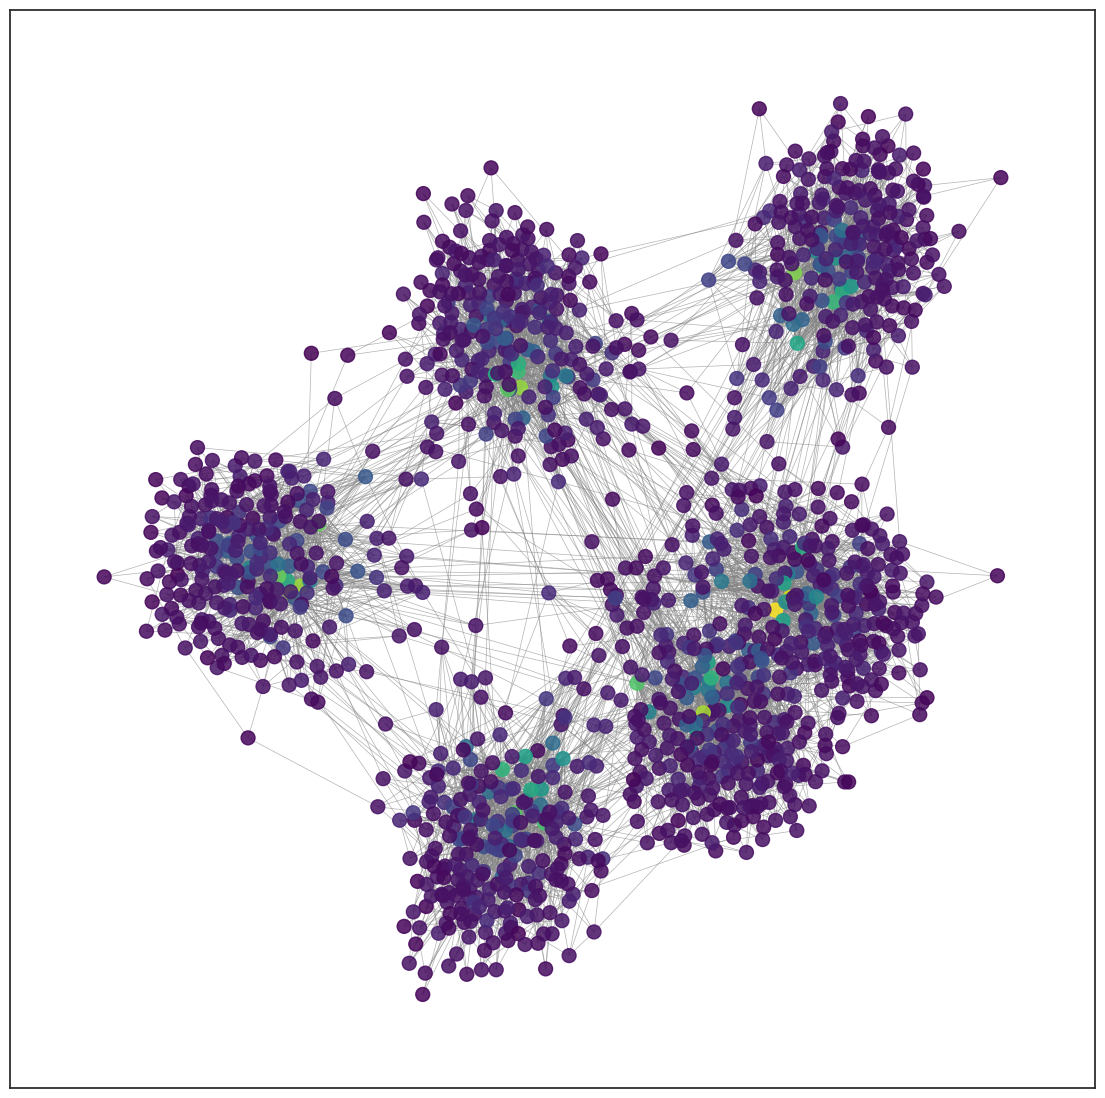

In [3]:
# Set Seaborn style for graph
sns.set_theme(style="white", context="notebook", font_scale=1.5)
plt.figure(figsize=(14, 14))

pos = nx.spring_layout(G, seed=123)  

# Calculate degrees of each node (how many links node has)
node_degrees = dict(G.degree())

# Generate a list of colors based on degree values
degree_colours = [node_degrees[node] for node in G.nodes()]

# Draw nodes and edges separately for more control
nx.draw_networkx_nodes(
    G, pos,
    node_size=100,         
    node_color=degree_colours,
    cmap=plt.cm.viridis,
    alpha=0.85             
)

nx.draw_networkx_edges(
    G, pos,
    edge_color="gray",      
    width=0.5,              
    alpha=0.6               
)

In [4]:
def extract_features(graph, node1, node2, attributes):
    features = {}
    
    # Common Neighbors
    features["common_neighbours"] = len(list(nx.common_neighbors(graph, node1, node2)))
    
    # Degree Centrality
    degree_centrality = nx.degree_centrality(graph)
    features["degree_centrality_node1"] = degree_centrality[node1]
    features["degree_centrality_node2"] = degree_centrality[node2]
    
    # Similarity in node attributes
    attr1 = attributes.loc[node1, "attribute"]
    attr2 = attributes.loc[node2, "attribute"]
    features["similarity"] = 1 if attr1 == attr2 else 0
    
    # Jaccard Coefficient
    jaccard = nx.jaccard_coefficient(graph, [(node1, node2)])
    features["jaccard_coefficient"] = next(jaccard)[2]
    
    # Preferential Attachment
    pref_at = nx.preferential_attachment(graph, [(node1, node2)])
    features["preferential_attachment"] = next(pref_at)[2]

    # Adamic-Adar Index
    adamic_adar = nx.adamic_adar_index(graph, [(node1, node2)])
    features["adamic_adar"] = next(adamic_adar)[2]

    # Resource Allocation
    resource_allocation = nx.resource_allocation_index(graph, [(node1, node2)])
    features["resource_allocation"] = next(resource_allocation)[2]

    # Clustering Coefficient
    clustering_coeff = nx.clustering(graph)
    features["clustering_coefficient_node1"] = clustering_coeff[node1]
    features["clustering_coefficient_node2"] = clustering_coeff[node2]

    # Community information
    community_node1 = node_to_community[node1]
    community_node2 = node_to_community[node2]
    features["same_community"] = 1 if community_node1 == community_node2 else 0
    
    return features

def generate_negative_examples(graph, num_examples):
    negative_examples = set()
    nodes = list(graph.nodes())
    while len(negative_examples) < num_examples:
        # Randomly select two nodes
        node1, node2 = random.sample(nodes, 2)
        if not graph.has_edge(node1, node2):
            negative_examples.add((node1, node2))

    return negative_examples

In [5]:
# Positive examples from the graph's existing edges
positive_examples = list(G.edges())

# Negative examples (same number as positive examples)
negative_examples = generate_negative_examples(G, len(positive_examples))

# Labels: 1 for positive, 0 for negative
positive_labels = [1] * len(positive_examples)
negative_labels = [0] * len(negative_examples)

# Combine the examples
all_examples = positive_examples + list(negative_examples)
all_labels = positive_labels + negative_labels

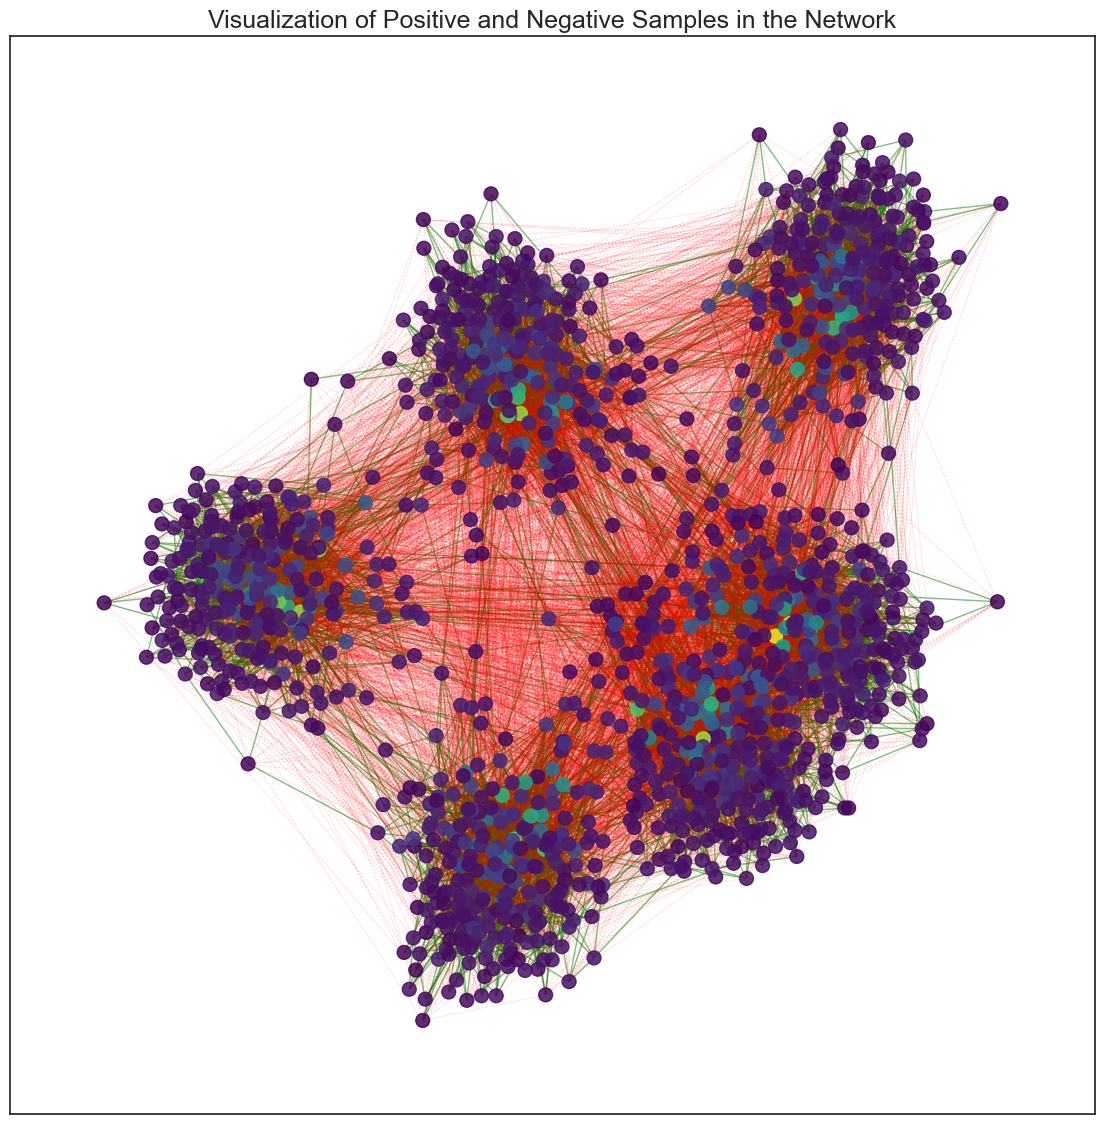

In [6]:
sns.set_theme(style="white", context="notebook", font_scale=1.5)
plt.figure(figsize=(14, 14))

# Use spring layout for node positioning
pos = nx.spring_layout(G, seed=123)  

# Calculate degrees of each node (how many links node has)
node_degrees = dict(G.degree())

# Generate a list of colors based on degree values
degree_colours = [node_degrees[node] for node in G.nodes()]

# Draw the nodes
nx.draw_networkx_nodes(
    G, pos,
    node_size=100,         
    node_color=degree_colours,
    cmap=plt.cm.viridis,
    alpha=0.85             
)

# Draw the positive edges (existing links)
nx.draw_networkx_edges(
    G, pos,
    edgelist=positive_examples,
    edge_color="green",
    width=1.0,
    alpha=0.5
)

# Draw the negative edges (non-existent links)
nx.draw_networkx_edges(
    G, pos,
    edgelist=negative_examples,
    edge_color="red",
    style="dashed",
    width=0.5,
    alpha=0.2
)

plt.title("Visualization of Positive and Negative Samples in the Network")
plt.show()

In [7]:
train_val_examples, test_examples, train_val_labels, test_labels = train_test_split(
    all_examples, all_labels, test_size=0.2, random_state=123, stratify=all_labels)

train_examples, val_examples, train_labels, val_labels = train_test_split(
    train_val_examples, train_val_labels, test_size=0.25, random_state=123, stratify= train_val_labels)

# Extract features for the training, validation and test sets
train_features = [extract_features(G, node[0], node[1], attributes) for node in train_examples]
val_features = [extract_features(G, node[0], node[1], attributes) for node in val_examples]
test_features = [extract_features(G, node[0], node[1], attributes) for node in test_examples]
kaggle_features = [extract_features(G, row["node1"], row["node2"], attributes) for _, row in kaggle_test.iterrows()]

# Convert the extracted features to DataFrames
train_features_df = pd.DataFrame(train_features)
val_features_df = pd.DataFrame(val_features)
test_features_df = pd.DataFrame(test_features)
kaggle_features_df = pd.DataFrame(kaggle_features)

# Add labels to the DataFrames
train_features_df["label"] = train_labels
val_features_df["label"] = val_labels
test_features_df["label"] = test_labels

In [8]:
X_train = train_features_df.drop(columns=["label"])
y_train = train_features_df["label"]

X_val = val_features_df.drop(columns=["label"])
y_val = val_features_df["label"]

X_test = test_features_df.drop(columns=["label"])
y_test = test_features_df["label"]

# Add interaction terms to capture feature interactions
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)

# Transform the training, validation, and test sets
X_train_poly = poly.fit_transform(X_train)
X_val_poly = poly.transform(X_val)
X_test_poly = poly.transform(X_test)
X_kaggle_poly = poly.transform(kaggle_features_df)

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler on the training sets and transform it
X_train_scaled = scaler.fit_transform(X_train_poly)

# Apply the same transformation to the validation and test sets
X_val_scaled = scaler.transform(X_val_poly)
X_test_scaled = scaler.transform(X_test_poly)
X_kaggle_scaled = scaler.transform(X_kaggle_poly)

In [9]:
# Feature Selection
selector = SelectKBest(score_func=f_classif, k=10)
X_train_selected = selector.fit_transform(X_train_scaled, y_train)
X_val_selected = selector.transform(X_val_scaled)
X_test_selected = selector.transform(X_test_scaled)
X_kaggle_selected = selector.transform(X_kaggle_scaled)

selected_features = poly.get_feature_names_out()[selector.get_support()]
print("Selected features: ", selected_features)

Selected features:  ['degree_centrality_node1' 'similarity' 'same_community'
 'degree_centrality_node1 similarity'
 'degree_centrality_node1 jaccard_coefficient'
 'degree_centrality_node1 same_community'
 'degree_centrality_node2 same_community' 'similarity same_community'
 'jaccard_coefficient same_community'
 'clustering_coefficient_node2 same_community']


In [10]:
lr = LogisticRegression(max_iter=1000, random_state=123)

param_grid = {
    "C": [0.001, 0.01, 0.1, 1, 10, 100],
    "penalty": ["l1", "l2", "elasticnet"],
    "solver": ["liblinear", "saga"],
    "l1_ratio": [0, 0.5, 1]
}

grid_search_lr = GridSearchCV(lr, param_grid, cv=5, n_jobs=-1, scoring="accuracy")

In [12]:
grid_search_lr.fit(X_train_selected, y_train)

best_lr = grid_search_lr.best_estimator_

best_lr.fit(X_train_selected, y_train)

y_val_pred_lr = best_lr.predict(X_val_selected)

val_accuracy_lr = accuracy_score(y_val, y_val_pred_lr)
classification_lr= classification_report(y_val, y_val_pred_lr)

print(f"Best Hyperparameters: {best_lr}")
print(f"Validation Accuracy: {val_accuracy_lr:.2f}")
print(f"Classification Report:\n{classification_lr}")

/opt/miniconda3/envs/fds/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/miniconda3/envs/fds/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/miniconda3/envs/fds/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/miniconda3/envs/fds/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/miniconda3/envs/fds/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  

Best Hyperparameters: LogisticRegression(C=0.1, l1_ratio=0, max_iter=1000, random_state=123,
                   solver='saga')
Validation Accuracy: 0.88
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.83      0.87      1320
           1       0.85      0.92      0.88      1320

    accuracy                           0.88      2640
   macro avg       0.88      0.88      0.88      2640
weighted avg       0.88      0.88      0.88      2640



/opt/miniconda3/envs/fds/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/miniconda3/envs/fds/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/opt/miniconda3/envs/fds/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/opt/miniconda3/envs/fds/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/opt/miniconda3/envs/fds/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  

In [17]:
rf = RandomForestClassifier(random_state=123)

param_grid_rf = {
    "n_estimators": [50, 100, 200, 300, 500],
    "max_depth": [None, 10, 20, 30],
    "min_samples_split": [25, 50, 100],
    "min_samples_leaf": [1, 2, 4, 10],
    "bootstrap": [True, False]
}

grid_search_rf = GridSearchCV(rf, param_grid_rf, cv=5, n_jobs=-1, scoring="accuracy")

In [18]:
grid_search_rf.fit(X_train_selected, y_train)

best_rf = grid_search_rf.best_estimator_

best_rf.fit(X_train_selected, y_train)

y_val_pred_rf = best_rf.predict(X_val_selected)

val_accuracy_rf = accuracy_score(y_val, y_val_pred_rf)
classification_rf = classification_report(y_val, y_val_pred_rf)

print(f"Best Hyperparameters for Random Forest: {best_rf}")
print(f"Validation Accuracy for Random Forest: {val_accuracy_rf:.2f}")
print(f"Classification Report for Random Forest:\n{classification_rf}")

Best Hyperparameters for Random Forest: RandomForestClassifier(max_depth=10, min_samples_split=50, random_state=123)
Validation Accuracy for Random Forest: 0.89
Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.90      0.87      0.88      1320
           1       0.87      0.90      0.89      1320

    accuracy                           0.89      2640
   macro avg       0.89      0.89      0.89      2640
weighted avg       0.89      0.89      0.89      2640



In [19]:
xgb = XGBClassifier(random_state=123)

param_grid = {
    "n_estimators": [100, 200, 300],
    "learning_rate": [0.01, 0.1, 0.2],
    "max_depth": [3, 5, 7],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0]
}

grid_search_xgb = GridSearchCV(xgb, param_grid, cv=5, scoring="accuracy", n_jobs=-1)

In [20]:
grid_search_xgb.fit(X_train_selected, y_train)

best_xgb = grid_search_xgb.best_estimator_

best_xgb.fit(X_train_selected, y_train)

y_val_pred_xgb = best_xgb.predict(X_val_selected)

val_accuracy_xgb = accuracy_score(y_val, y_val_pred_xgb)
classification_xgb = classification_report(y_val, y_val_pred_xgb)

print(f"Best Hyperparameters for XGBoost: {best_xgb}")
print(f"Validation Accuracy for XGBoost: {val_accuracy_xgb:.2f}")
print(f"Classification Report for XGBoost:\n{classification_xgb}")

Best Hyperparameters for XGBoost: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=123, ...)
Validation Accuracy for XGBoost: 0.89
Classification Report for XGBoost:
              precision    recall  f1-score   support

           0       0.90      0.87      0.88      1320
           1       0.87      0.91

In [24]:
y_test_pred_log_reg_local = best_lr.predict(X_test_selected)

test_accuracy_lr = accuracy_score(y_test, y_test_pred_log_reg_local)
classification_lr = classification_report(y_test, y_test_pred_log_reg_local)

print(f"Test Accuracy for Logistic Regression: {test_accuracy_lr:.2f}")
print(f"Classification Report for Logistic Regression:\n{classification_lr}")

Test Accuracy for Logistic Regression: 0.89
Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.93      0.84      0.88      1320
           1       0.85      0.94      0.89      1320

    accuracy                           0.89      2640
   macro avg       0.89      0.89      0.89      2640
weighted avg       0.89      0.89      0.89      2640



In [25]:
y_test_pred_rf_local = best_rf.predict(X_test_selected)
test_accuracy_rf = accuracy_score(y_test, y_test_pred_rf_local)
classification_rf = classification_report(y_test, y_test_pred_rf_local)

print(f"Test Accuracy for Random Forest: {test_accuracy_rf:.2f}")
print(f"Classification Report for Random Forest:\n{classification_rf}")

Test Accuracy for Random Forest: 0.89
Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.90      0.87      0.88      1320
           1       0.87      0.90      0.89      1320

    accuracy                           0.89      2640
   macro avg       0.89      0.89      0.89      2640
weighted avg       0.89      0.89      0.89      2640



In [30]:
y_test_pred_xgb_local = best_xgb.predict(X_test_selected)
test_accuracy_xgb = accuracy_score(y_test, y_test_pred_xgb_local)
classification_xgb = classification_report(y_test, y_test_pred_xgb_local)

print(f"Test Accuracy for Random Forest: {test_accuracy_xgb:.2f}")
print(f"Classification Report for Random Forest:\n{classification_xgb}")

Test Accuracy for Random Forest: 0.88
Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.91      0.86      0.88      1320
           1       0.87      0.91      0.89      1320

    accuracy                           0.88      2640
   macro avg       0.89      0.88      0.88      2640
weighted avg       0.89      0.88      0.88      2640



In [31]:
# Logistic Regression model
y_test_pred_log_reg = best_lr.predict(X_kaggle_selected)
pd.DataFrame(y_test_pred_log_reg).to_csv("../datasets/prediction_lr.csv", index=True, header=["prediction"], index_label="ID")

In [32]:
# Random Forest model
y_test_pred_rf = best_rf.predict(X_kaggle_selected)
pd.DataFrame(y_test_pred_rf).to_csv("../datasets/prediction_rf.csv", index=True, header=["prediction"], index_label="ID")

In [33]:
# Gradient Boost
y_test_pred_xgb = best_xgb.predict(X_kaggle_selected)
pd.DataFrame(y_test_pred_xgb).to_csv("../datasets/prediction_xgb.csv", index=True, header=["prediction"], index_label="ID")